# Windy Gridworld Class

![title](windy_gridworld_pic.png)

# Load Packages

In [1]:
import gym
from gym import error, spaces, utils
from io import StringIO
import sys
import numpy as np
import matplotlib.pyplot as plt

# Class Object 

In [2]:
class WindygwEnv():
    
    metadata = {'render.modes': ['human']}
    
    def __init__(self):
        
        # Grid size
        self.grid_rows = 7
        self.grid_cols = 10

        # Locations
        self.start = [3, 0]
        self.goal = [3, 7]
        
        # Wind Strength 
        self.wind = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
        
        # Grid matrix
        self.grid = np.full((7, 10), "-")
        self.grid[self.start[0],self.start[1]] = "S"
        self.grid[self.goal[0],self.goal[1]] = "G"

        # Action set 0=Up 1=Down 2=Left 3=Right
        self.actions = range(4)
        self.action_letters = ["Up","Down","Left","Right"]

        # Reward at Each Step
        self.reward = -1
        
        # Action space
        self.action_space =  spaces.Discrete(len(self.actions))
        
        # Observation space
        self.observation_space = spaces.Tuple((spaces.Discrete(self.grid_rows),
                                              spaces.Discrete(self.grid_cols)))
    
    # Initialize state location
    def reset(self):
        
        self.state = self.start
        return self.state
    
    # Function to move through environment
    def step(self, action):
        
        self.lasta = action
        rownum, colnum = self.state
    
        # 0=Up
        if action==0:
            rownum = max( rownum -1 -self.wind[colnum], 0 )
    
        # 1=Down
        elif action==1:
            rownum = max( min( rownum +1 -self.wind[colnum], self.grid_rows-1 ), 0 )
    
        # 2=Left
        elif action==2:
            rownum = max( rownum -self.wind[colnum], 0 )
            colnum = max( colnum -1, 0 )
    
        # 3=Right
        else:
            rownum = max( rownum -self.wind[colnum], 0 )
            colnum = min( colnum +1, self.grid_cols-1 )
        
        # Update internal state location
        self.state = [rownum, colnum]
        
        # Indicator for episode end
        if self.state == self.goal:
            done = True
        else:
            done = False
            
        # Return new state, reward received, episode end indicator, additional information
        return self.state, self.reward, done, {}
       
    # Print the state of the agent in the environment
    def render(self, mode="human"):
        
        # Initialize streaming file
        outfile = StringIO() if mode == "ansi" else sys.stdout

        # convert grid to list
        agent_loc = self.grid.copy()
        agent_loc[self.state[0],self.state[1]] = "A"
        agent_loc = agent_loc.tolist()

        # Specify colors
        agent_loc[self.start[0]][self.start[1]] = utils.colorize(agent_loc[self.start[0]][self.start[1]], color="blue", highlight=False)
        agent_loc[self.goal[0]][self.goal[1]] = utils.colorize(agent_loc[self.goal[0]][self.goal[1]], color="red", highlight=False)
        agent_loc[self.state[0]][self.state[1]] = utils.colorize(agent_loc[self.state[0]][self.state[1]], color="green", highlight=True)

        # Print action and environment
        outfile.write("\n"+str(self.action_letters[self.lasta])+"\n")
        outfile.write("\n".join("".join(line) for line in agent_loc) + "\n")

# Make Environment

In [3]:
env = WindygwEnv()

# House Keeping

In [4]:
# Set a Seed
np.random.seed(802)

# Grid size
grid_rows = env.observation_space[0].n
grid_cols = env.observation_space[1].n

# Action set 0=Up 1=Down 2=Left 3=Right
actions = range(env.action_space.n)

# Step Size
alpha = 0.5

# Exploration Rate
epsilon = 0.1

# Set number of episodes to run
episodes = 250

# Q Table

In [5]:
q_table = np.zeros([grid_rows, grid_cols, len(actions)])

# Greedy Action Function

In [6]:
def greedy(state, q_table, epsilon):
    
    # Randomly select action with probability epsilon
    if np.random.uniform() < epsilon:
        g_action = np.random.choice(actions)
        
    # Select the best action for the given state with probability 1-epsilon
    else:
        q_vals = q_table[state[0], state[1], :]
        q_vals_max = np.where(q_vals==q_vals.max())[0]
        g_action = np.random.choice(q_vals_max)
    
    return g_action

# Q-Learning

In [7]:
# Store the steps to reach the goal for each episode
steps_vec = []

# Q-Learning
for i in range(episodes):
    
    # Count steps per episode
    steps_count = 0
    
    # Always start in the same position
    state = env.reset()
    
    # Goal reached indicator to end episode
    episode_end = False
    
    # Loop until the goal is reached
    while episode_end != True:
        
        # Choose action based on epsilon-greedy
        action = greedy(state, q_table, epsilon)
        
        # Find next state given current state and action
        new_state, reward, episode_end, info = env.step(action)
        
        # Update the q-table with Q-Learning
        q_table[state[0],state[1],action] =  q_table[state[0],state[1],action] + \
            alpha * ( reward + max(q_table[new_state[0],new_state[1],]) - \
            q_table[state[0],state[1],action] )

        # Set new state to current state
        state = new_state
        
        # Update steps count
        steps_count += 1
        
    steps_vec.append(steps_count)

# View Results

In [8]:
min_steps = min(steps_vec)
optimal_path_count = sum(np.array(steps_vec)==min_steps)
print("The agent followed the optimal path", 100*optimal_path_count/episodes, "% of the time with Q-Learning.")

The agent followed the optimal path 15.2 % of the time with Q-Learning.


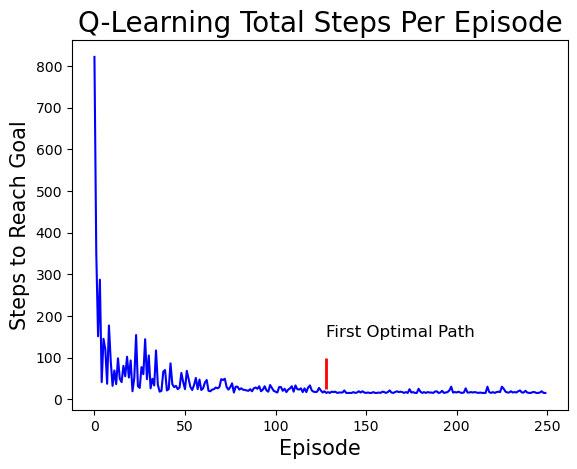

In [9]:
plt.plot(steps_vec, color="blue")
plt.title("Q-Learning Total Steps Per Episode", fontsize=20)
plt.xlabel("Episode", fontsize=15)
plt.ylabel("Steps to Reach Goal", fontsize=15)
plt.text(steps_vec.index(min_steps),150,"First Optimal Path", fontsize=12)
plt.vlines(x=steps_vec.index(min_steps), ymin=25, ymax=100, color='red', lw=2)
plt.show()

# Render Agent and Environment

In [10]:
# Initialize environment
state = env.reset()
episode_end = False

# View optimal agent path
while episode_end != True:
    
    # Use optimal action from q-table
    action = np.argmax(q_table[state[0],state[1],:])
    state, reward, episode_end, info = env.step(action)
    env.render()


Right
----------
----------
----------
SA-----G--
----------
----------
----------

Right
----------
----------
----------
S-A----G--
----------
----------
----------

Right
----------
----------
----------
S--A---G--
----------
----------
----------

Right
----------
----------
----A-----
S------G--
----------
----------
----------

Right
----------
-----A----
----------
S------G--
----------
----------
----------

Right
------A---
----------
----------
S------G--
----------
----------
----------

Right
-------A--
----------
----------
S------G--
----------
----------
----------

Right
--------A-
----------
----------
S------G--
----------
----------
----------

Right
---------A
----------
----------
S------G--
----------
----------
----------

Down
----------
---------A
----------
S------G--
----------
----------
----------

Down
----------
----------
---------A
S------G--
----------
----------
----------

Down
----------
----------
----------
S------G-A
----------
----------
------